In [2]:
import pandas as pd
import os
import numpy as np

import get_votos

import networkx as nx
import requests
import matplotlib.pyplot as plt


from matplotlib import rcParams
from cycler import cycler

from operator import itemgetter
import collections

import chart_studio
import plotly.graph_objs as go
chart_studio.tools.set_credentials_file(username='felipe84zt',api_key='F03ELIAc0CCcvrQ3cdXx')

In [2]:
#these colors come from colorbrewer2.org. Each is an RGB triplet
dark2_colors = [(0.10588235294117647, 0.6196078431372549, 0.4666666666666667),
                (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
                (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),
                (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
                (0.4, 0.6509803921568628, 0.11764705882352941),
                (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
                (0.6509803921568628, 0.4627450980392157, 0.11372549019607843),
                (0.4, 0.4, 0.4)]
rcParams['figure.figsize'] = (10, 6)
rcParams['figure.dpi'] = 150
rcParams['axes.prop_cycle'] = cycler(color=dark2_colors)
rcParams['lines.linewidth'] = 2
rcParams['axes.grid'] = False
rcParams['axes.facecolor'] = 'white'
rcParams['font.size'] = 14
rcParams['patch.edgecolor'] = 'none'

def remove_border(axes=None, top=False, right=False, left=True, bottom=True):
    """
    Minimize chartjunk by stripping out unnecessary plot borders and axis ticks
    
    The top/right/left/bottom keywords toggle whether the corresponding plot border is drawn
    """
    ax = axes or plt.gca()
    ax.spines['top'].set_visible(top)
    ax.spines['right'].set_visible(right)
    ax.spines['left'].set_visible(left)
    ax.spines['bottom'].set_visible(bottom)
    
    #turn off all ticks
    ax.yaxis.set_ticks_position('none')
    ax.xaxis.set_ticks_position('none')
    
    #now re-enable visibles
    if top:
        ax.xaxis.tick_top()
    if bottom:
        ax.xaxis.tick_bottom()
    if left:
        ax.yaxis.tick_left()
    if right:
        ax.yaxis.tick_right()

In [4]:
rootPath1=r'C:\Users\Felipe\Documents\GitHub\IntroDS-Projeto-Final\Data3\56-LEG-PRIMEIRA-SESSAO-LEGISLATIVA-Fevereiro19'
rootPath2=r'C:\Users\Felipe\Documents\GitHub\IntroDS-Projeto-Final\Data3\56-LEG-PRIMEIRA-SESSAO-LEGISLATIVA-Março19'
rootPat3=r'C:\Users\Felipe\Documents\GitHub\IntroDS-Projeto-Final\Data3\56-LEG-PRIMEIRA-SESSAO-LEGISLATIVA-Abril19'
rootPath4=r'C:\Users\Felipe\Documents\GitHub\IntroDS-Projeto-Final\Data3\56-LEG-PRIMEIRA-SESSAO-LEGISLATIVA-Maio19'
rootPath5=r'C:\Users\Felipe\Documents\GitHub\IntroDS-Projeto-Final\Data3\56-LEG-PRIMEIRA-SESSAO-LEGISLATIVA-Junho19'
rootPath6=r'C:\Users\Felipe\Documents\GitHub\IntroDS-Projeto-Final\Data3\56-LEG-PRIMEIRA-SESSAO-LEGISLATIVA-Julho19'

rootPath6=r'C:\Users\Felipe\Documents\GitHub\IntroDS-Projeto-Final\Votos\Votos_2014'

arquivo='Abril2019.csv'
arquivo2='Maio2019.csv'

arquivo2='votos2011.csv'

#filename=os.path.join(rootPath,arquivo)
#filename2=os.path.join(rootPath2,arquivo2)

#df_abril=get_votos.votos(rootPath)
#df_maio=get_votos.votos(rootPath2)
#df_marco=get_votos.votos(rootPath3)
#df_junho=get_votos.votos(rootPath4)
#df_julho=get_votos.votos(rootPath5)

vt_fev=get_votos.votos(rootPath1)

In [22]:
#vt_fev['Estado'].unique()
#vt_fev[vt_fev['Estado']=='17 Rio de Janeiro']
#vt_fev['Estado'].iloc[314]='Rio de Janeiro'
#vt_fev['Partido'].value_counts()
#df_pp.to_csv(r'C:\Users\Felipe\Documents\GitHub\IntroDS-Projeto-Final\Site\parlamentares_por_partido.csv')

In [19]:
def lado_partido(df_mes):
    
    GOVERNO=['PSL','PP','PSD','MDB','PR','PRB','DEM','PSDB','PTB','PMN','PSC','NOVO','PTC','PHS']
    MINORIA=['PDT','AVANTE','Avate','PATRI','PV','PROS','PPS','CIDADANIA','SOLIDARIEDADE','Solidariedade',\
             'PODE','PL','DC','PRP','PATRIOTA','Patriota','Podemos','S.Part.']
    OPOSICAO=['PT','PSOL','PSB','REDE','PCdoB','PPL']
    df_mes['Lado']=0
    for i in range(len(df_mes['Partido'])):
        if df_mes['Partido'].iloc[i] in GOVERNO:
            df_mes['Lado'].iloc[i]='GOVERNO'
        elif df_mes['Partido'].iloc[i] in OPOSICAO:
            df_mes['Lado'].iloc[i]='OPOSIÇÃO'
        elif df_mes['Partido'].iloc[i] in MINORIA:
            df_mes['Lado'].iloc[i]='MINORIA'
        else:
            print(df_mes['Partido'].iloc[i])
            print(i)

In [21]:
lado_partido(vt_fev)

In [245]:
def rede_votos2(df_mes):
    
    partidos = list(df_mes['Partido'].unique())
    pesos= {dep:{ped: 0 for ped in partidos if ped!=dep} for dep in partidos}
    df=pd.DataFrame(columns=['Source','Target','Type','Weight','Start','End'])
    
    tipos_votos=['Não', 'Sim','Abstenção','Obstrução']
    df_colunas=list(df_mes.columns[1:])
    
    for pos,sessao in enumerate(df_colunas): # pega a coluna da sessao
        
        votos_sessao=list(df_mes[[sessao]].values) #pega todos os votos da sessao
        
        
        for ordem1,v1 in enumerate(votos_sessao):
                    
            for ordem2,v2 in enumerate(votos_sessao[ordem1+1:],start=(ordem1+1)):
                
                if str(v1)==str(v2):
                    dep1=partidos[ordem1]
                    dep2=partidos[ordem2]
                    pesos[dep1][dep2]+=1
                    df=df.append({'Source':dep1,'Target':dep2,'Type':'Undirected',\
                                  'Weight':pesos[dep1][dep2],'Start':pos,'End':pos+1},\
                                 ignore_index=True)
                else:
                    dep1=partidos[ordem1]
                    dep2=partidos[ordem2]
                    
                    df=df.append({'Source':dep1,'Target':dep2,'Type':'Undirected',\
                                  'Weight':pesos[dep1][dep2],'Start':pos,'End':pos+1},\
                                 ignore_index=True)
                
                    
        
        print('Iteracao: ',pos)
            
    return df

In [178]:
def df_partidos(df_mes):
    
    df=pd.DataFrame()
    df_colunas=list(df_mes.columns[4:-1])
    partidos=df_mes['Partido'].unique()
    for pos,sessao in enumerate(df_colunas):
        df2=pd.DataFrame()
        for par in partidos:
            
            teste=df_mes[df_mes['Partido']==par]
            votos=[0,0,0,0,0]

            for j in teste[sessao].unique():
                if j=='Sim':
                    votos[0]=(teste[sessao].value_counts()[j])
                elif j=='Não':
                    votos[1]=(teste[sessao].value_counts()[j])
                elif j=='Abstenção':
                    votos[2]=(teste[sessao].value_counts()[j])
                elif j=='Obstrução':
                    votos[3]=(teste[sessao].value_counts()[j])
                elif j=='Não Votou':
                    votos[4]=(teste[sessao].value_counts()[j])
                elif j=='Art.':
                    pass
                else:
                    print('Erro')
                    print(j)

            resultado_s=votos[0]/sum(votos)
            resultado_n=sum(votos[1:4])/sum(votos)
            if pos==0:
                
                if resultado_s==resultado_n:
                    df=df.append({sessao:'Não Votou','Partido':par},ignore_index=True)
                elif resultado_s>resultado_n:
                    df=df.append({sessao:'Sim','Partido':par},ignore_index=True)
                else:
                    df=df.append({sessao:'Não','Partido':par},ignore_index=True)
            else:
                if resultado_s==resultado_n:
                    df2=df2.append({'Partido':par,sessao:'Não Votou'},ignore_index=True)
                elif resultado_s>resultado_n:
                    df2=df2.append({'Partido':par,sessao:'Sim'},ignore_index=True)
                else:
                    df2=df2.append({'Partido':par,sessao:'Não'},ignore_index=True)
        
        if pos==0:
            pass
        else:
            df=pd.merge(df,df2,on='Partido')
            
    df=df[sorted(df.columns.values,reverse=True)]            
    return df

In [242]:
df=df_partidos(vt_fev)

In [347]:
for j,i in enumerate(vt_nodes['Id'].unique()):
  
    vt_nodes['Quantidade'].iloc[j]=vt_fev['Id'].value_counts()[i]
    

In [369]:
votos.to_csv(r'C:\Users\Felipe\Documents\GitHub\IntroDS-Projeto-Final\Site\part_edges3.csv',sep=';',index=False)

In [57]:
def rede_votos(df_mes):
    
    deputados = df_mes['Nome']
    pesos= {dep:{ped: 0 for ped in deputados if ped!=dep} for dep in deputados}
    
    redes=[]
    
    tipos_votos=['Não', 'Sim','Abstenção','Obstrução']
    for pos,sessao in enumerate(df_mes.columns[4:]): # pega a coluna da sessao
        
        votos_sessao=df_mes[sessao] #pega todos os votos da sessao
            
        votou_sim=[]
        votou_nao=[]
        votou_abs=[]
        votou_obs=[]
        for ordem,v in enumerate(votos_sessao): #pega um voto da lista
            if v not in tipos_votos: #verifica se o deputado votou
                continue
            elif v=='Não':
                votou_nao.append(ordem)
            elif v=='Sim':
                votou_sim.append(ordem)
            elif v=='Abstenção':
                votou_abs.append(ordem)
            elif v=='Obstrução':
                votou_obs.append(ordem)
            
        for k1,dp1 in enumerate(votou_sim):
            for p2,dp2 in enumerate(votou_sim[k1+1:]):
               
                pesos[deputados.iloc[dp1]][deputados.iloc[dp2]]+=1
                
        #for k1,dp1 in enumerate(votou_sim):
            #for p2,dp2 in enumerate(votou_nao):
                #if pesos[deputados.iloc[dp1]][deputados.iloc[dp2]]>0:
                    #pesos[deputados.iloc[dp1]][deputados.iloc[dp2]]-=1        
                
        for k1,dp1 in enumerate(votou_nao):
            for p2,dp2 in enumerate(votou_nao[k1+1:]):
               
                pesos[deputados.iloc[dp1]][deputados.iloc[dp2]]+=1
                
        for k1,dp1 in enumerate(votou_abs):
            for p2,dp2 in enumerate(votou_abs[k1+1:]):
               
                pesos[deputados.iloc[dp1]][deputados.iloc[dp2]]+=1
                
        for k1,dp1 in enumerate(votou_obs):
            for p2,dp2 in enumerate(votou_obs[k1+1:]):
               
                pesos[deputados.iloc[dp1]][deputados.iloc[dp2]]+=1                
                    
        g = nx.Graph()
        for par,nome in enumerate(deputados):
            g.add_node(nome)
            if df_mes['Lado'].iloc[par]=='GOVERNO':
                g.node[nome]['color'] ='b'
            elif df_mes['Lado'].iloc[par]=='PMDB':
                g.node[nome]['color'] ='r'
            elif df_mes['Lado'].iloc[par]=='PSDB':
                g.node[nome]['color'] ='y'
            elif df_mes['Lado'].iloc[par]=='CENTRAO':
                g.node[nome]['color'] ='g'
            elif df_mes['Lado'].iloc[par]=='DEM':
                g.node[nome]['color'] ='m'
            else:
                g.node[nome]['color'] ='w'
    
        for dep1, vizinho in pesos.items():
            for dep2, peso in vizinho.items():
                if peso == 0:
                    continue
                g.add_edge(dep1,dep2, weight= peso, difference = 1. / peso)
            
    return g

In [25]:
def mst_votes(votes_net_mes,nomes_dep=True,labels='all'):
    
    plt.figure(figsize=(15, 10))
    np.random.seed(5)
    mst = nx.minimum_spanning_tree(votes_net_mes, weight='difference')
    pos = nx.spring_layout(mst, iterations=900, k=.008, weight='difference')


    mst_edges = list(nx.minimum_spanning_edges(votes_net_mes, weight='difference'))

    nl = votes_net_mes.nodes()
    c = [votes_net_mes.node[n]['color'] for n in nl]


    nx.draw_networkx_edges(votes_net_mes, pos, edgelist=mst_edges, alpha=0.8)
    nx.draw_networkx_nodes(votes_net_mes, pos, nodelist = nl, node_color = c, node_size=60)

    for p in pos.values():
        p[1] += .02
    
    if nomes_dep==True:
        if labels=='all':
            
            nx.draw_networkx_labels(votes_net_mes, pos, font_color='k', font_size=5)
        else:
            nx.draw_networkx_labels(votes_net_mes, pos,labels, font_color='k', font_size=8)
        
    plt.title("MST of Vote Disagreement", fontsize=12)
    plt.xticks([])
    plt.yticks([])
    remove_border(left=False, bottom=False)
    
    return mst



In [101]:
def rede_est_part(df_pe):
    print('Fase 0')
    deputados = df_pe['Nome']
    pesos= {dep:{ped: 0 for ped in deputados if ped!=dep} for dep in deputados}
    print('Fase 1')
    
    for a in range(len(df_pe)):
        estado1=df_pe['Estado'].iloc[a]
        for b in range(a+1,len(df_pe)):
            estado2=df_pe['Estado'].iloc[b]
            if estado1==estado2:
                pesos[df_pe['Nome'].iloc[a]][df_pe['Nome'].iloc[b]]+=1
    print('Fase 2')
    
    
    for a in range(len(df_pe)):
        estado1=df_pe['Partido'].iloc[a]
        for b in range(a+1,len(df_pe)):
            estado2=df_pe['Partido'].iloc[b]
            if estado1==estado2:
                pesos[df_pe['Nome'].iloc[a]][df_pe['Nome'].iloc[b]]+=1
    
    print('Fase 3')
    g = nx.Graph()
    for par,nome in enumerate(deputados):
        g.add_node(nome)
        if df_pe['Lado'].iloc[par]=='GOVERNO':
            g.node[nome]['color'] ='b'
        elif df_pe['Lado'].iloc[par]=='OPOSIÇÃO':
            g.node[nome]['color'] ='r'
        elif df_pe['Lado'].iloc[par]=='MINORIA':
            g.node[nome]['color'] ='y'
        else:
            g.node[nome]['color'] ='m'
    print('Fase 4')
    for dep1, vizinho in pesos.items():
        for dep2, peso in vizinho.items():
            if peso == 0:
                continue
            g.add_edge(dep1,dep2, weight= peso, difference = 1. / peso)
            
    return g

In [102]:
rede_estpar=rede_est_part(df_pe)

Fase 0
Fase 1
Fase 2
Fase 3
Fase 4


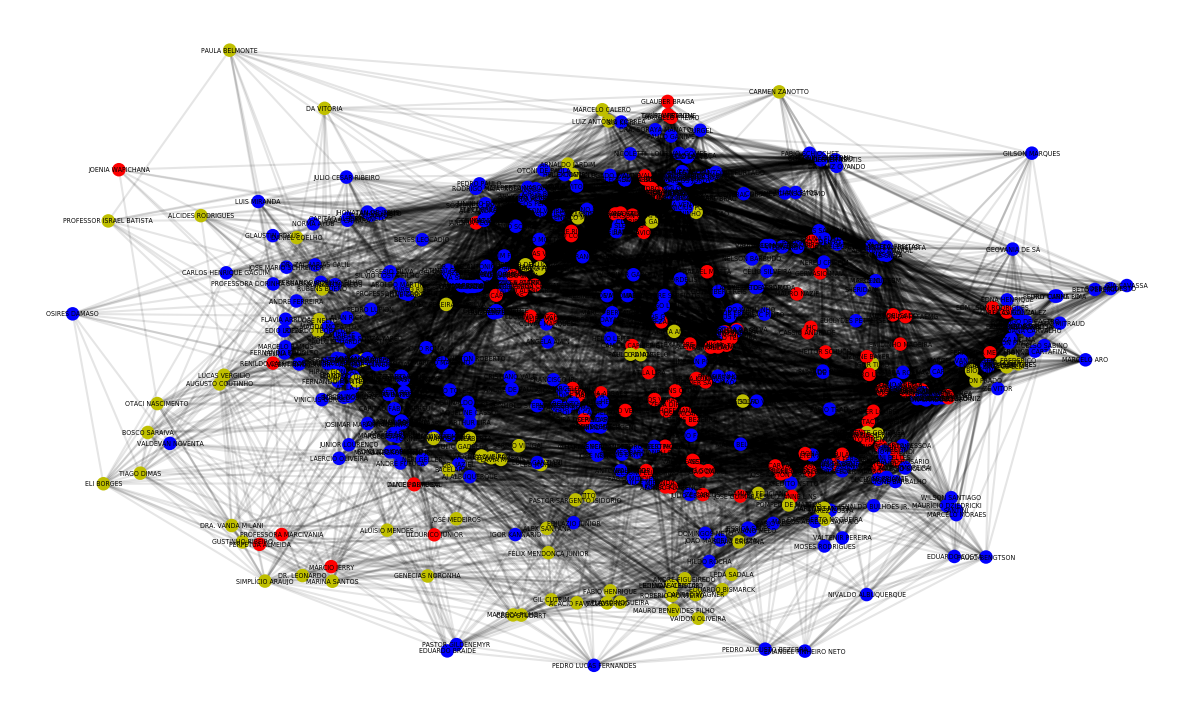

In [83]:
np.random.seed(1)  

color = [rede_estpar.node[deputado]['color'] for deputado in rede_estpar.nodes()]

pos = nx.spring_layout(rede_estpar, iterations=400)
nx.draw_networkx_edges(rede_estpar, pos, alpha = 0.1)
nx.draw_networkx_nodes(rede_estpar, pos, node_color=color,node_size=30)
lbls = nx.draw_networkx_labels(rede_estpar, pos, alpha=5, font_size=3)

plt.xticks([])
plt.yticks([])
remove_border(left=False, bottom=False)

## Majority Game

Para o jogador B, a cada rodada de votos, contabiliza-se a quantidade de votos dos seus vizinhos. Caso a proporção de votos dos seus vizinhos seja 'Sim' e o jogador B tenha votado 'Não', então o jogador B é penalizado. Caso contrário, B é premiado.

No nosso caso, inicialmente, ganha-se ou perde-se 1 ponto. No caso em que o parlamentar não votou, nada acontece.

(objetivo: fazer um majority game onde a fala previa estara relacionada ao payoff)

In [3]:
def maj_game(rede,df_mes,resultado_prev=0,rounds='all'):
    
    if rounds=='all':
        rounds=len(df_mes.columns)-5
        
    deputados=df_mes['Nome']
    resultado_est= {dep:0 for dep in deputados}
    resultado_part={dep:0 for dep in deputados}
    res_iter=[]
    
    serie_res_est={dep:[] for dep in deputados}
    serie_res_part={dep:[] for dep in deputados}
    
    erro=[]

    pesos= {dep:{ped: 0 for ped in deputados if ped!=dep} for dep in deputados}
    
    for rodada in range(rounds):
        for sessao in df_mes.iloc[:,4+rodada:5+rodada]:
            print('-----------------------------')
            print('Rodada: ',rodada)
            df=df_mes[['Nome',sessao]]
            
            for i in range(len(df)):
                
                nome=df['Nome'].iloc[i]
                if nome not in resultado.keys():
                    resultado[nome]=0
                    
                votou1=df[sessao].iloc[i]
                
                if votou1=='Não Votou':
                    continue
                elif votou1=='Art.':
                    continue
                votos_t_est=[]
                votos_t_part=[]
                
                votos_abs_est=[]
                votos_abs_part=[]
                
                estado1=df[df['Nome']==nome]['Estado'].item()
                partido1=df[df['Nome']==nome]['Partido'].item()
                
                for edge in rede.edges(nome):
                    
                    votos_t=0
                    votos_abs=0
                    
                    dep2=edge[1]
                    estado2=df[df['Nome']==dep2]['Estado'].item()
                    partido2=df[df['Nome']==dep2]['Partido'].item()
                    
                    if dep2 not in set(df['Nome']):
                        votou2='Art.'
                        erro.append(dep2)
                    else:
                        votou2=df[df['Nome']==dep2][sessao].item()
                    
                    if votou2=='Não':
                        votos_t=0
                    elif votou2=='Sim':
                        votos_t=1
                    elif votou2=='Não Votou':
                        pass
                    elif votou2=='Art.':
                        pass
                    elif votou2=='Obstrução':
                        votos_t=0
                    elif votou2=='Abstenção':
                        votos_abs=-1
                    else:
                        print('Erro',edge)
                        
                    if estado1==estado2:
                        votos_t_est.append(votos_t)
                        votos_abs_est.append(votos_abs)
                        
                    if partido1==partido2:
                        votos_t_part.append(votos_t)
                        votos_abs_part.append(votos_abs)
                        
                    if votou1==votou2:
                        pesos[deputados.iloc[nome]][deputados.iloc[edge]]+=1
                        
                        
                media_est=np.mean(votos_t_est)
                media_part=np.mean(votos_t_part)
                
                if media_est>0.5:
                    vencedor_est='Sim'
                elif media_est<=0.5:
                    vencedor_est='Não'
                    
                if media_part>0.5:
                    vencedor_part='Sim'
                elif media_part<=0.5:
                    vencedor_part='Não'
                
                if votou1=='Abstenção':
                    if (len(votos_t_est)+len(votos_t_part))==0:
                        print(sessao)
                        print(rede.edges(nome))
                        print(nome)
                        res=1
                    else:
                        res_est=len(votos_abs_est)/len(votos_t_est)
                        res_part=len(votos_abs_part)/len(votos_t_part)
            
                    
                    if res_est>0.5:
                        resultado_est[nome]+=1
                    else:
                        resultado_est[nome]-=1
                    
                    if res_part>0.5:
                        resultado_part[nome]+=1
                    else:
                        resultado_part[nome]-=1 
                        
                    continue
                        
                if votou1==vencedor_est:
                    resultado_est[nome]+=1
                    serie_res_est[nome].append(1)
                else:
                    resultado_est[nome]-=1
                    serie_res_est[nome].append(-1)
                    
                if votou1==vencedor_part:
                    resultado_part[nome]+=1
                    serie_res_part[nome].append(1)
                else:
                    resultado_part[nome]-=1
                    serie_res_part[nome].append(-1)
                    
                
        
        r=[(resultado_est.get(name),name) for name in resultado_est.keys()]
        
        t=0
        for i in sorted(r,reverse=True):
            
            print(i)
            t+=1
            if t==10:
                break
                
        print('-----------------------------')
        t=0
        for i in sorted(r,reverse=False):
            
            print(i)
            t+=1
            if t==10:
                break
        print('-----------------------------')
        res_iter_est.append(r)
        
    return resultado_est,resultado_part,pesos,r,erro,serie_res_est,serie_res_part

In [ ]:
maj_game()

In [330]:
jogo_marco,r,erro,serie=maj_game(rede_estpar,df_marco,rounds='all')

-----------------------------
Rodada:  0
(1, 'ÁUREA CAROLINA')
(1, 'ÁTILA LINS')
(1, 'ZÉ SILVA')
(1, 'WLADIMIR GAROTINHO')
(1, 'WELITON PRADO')
(1, 'WALDENOR PEREIRA')
(1, 'VINICIUS FARAH')
(1, 'VILSON DA FETAEMG')
(1, 'VICENTINHO')
(1, 'VERMELHO')
-----------------------------
(-1, 'ADRIANA VENTURA')
(-1, 'AFONSO HAMM')
(-1, 'ALCEU MOREIRA')
(-1, 'ALCIDES RODRIGUES')
(-1, 'ALEXIS FONTEYNE')
(-1, 'ALUISIO MENDES')
(-1, 'BETO PEREIRA')
(-1, 'CELSO MALDANER')
(-1, 'CHIQUINHO BRAZÃO')
(-1, 'DA VITÓRIA')
-----------------------------
-----------------------------
Rodada:  1
(2, 'ZÉ SILVA')
(2, 'WLADIMIR GAROTINHO')
(2, 'VINICIUS FARAH')
(2, 'VILSON DA FETAEMG')
(2, 'VICENTINHO')
(2, 'VERMELHO')
(2, 'VAVÁ MARTINS')
(2, 'VANDERLEI MACRIS')
(2, 'VANDER LOUBET')
(2, 'VALMIR ASSUNÇÃO')
-----------------------------
(-2, 'HERMES PARCIANELLO')
(-2, 'HILDO ROCHA')
(-2, 'IVAN VALENTE')
(-2, 'NEWTON CARDOSO JR')
(-1, 'AFONSO HAMM')
(-1, 'ALICE PORTUGAL')
(-1, 'BACELAR')
(-1, 'DANIEL ALMEIDA')
(-1, '

(16, 'SERGIO TOLEDO')
(16, 'ROGÉRIO PENINHA MENDONÇA')
(16, 'OTACI NASCIMENTO')
(16, 'MARCELO NILO')
(16, 'JÚNIOR FERRARI')
(16, 'JÚNIOR BOZZELLA')
(16, 'JAQUELINE CASSOL')
(16, 'DANIEL SILVEIRA')
(16, 'CRISTIANO VALE')
(16, 'CARLOS HENRIQUE GAGUIM')
-----------------------------
(-13, 'BACELAR')
(-13, 'GIOVANI FELTES')
(-13, 'NEWTON CARDOSO JR')
(-12, 'GUTEMBERG REIS')
(-11, 'EDMILSON RODRIGUES')
(-11, 'ENRICO MISASI')
(-11, 'GURGEL')
(-10, 'LUCAS GONZALEZ')
(-10, 'MARCELO CALERO')
(-10, 'ROSANA VALLE')
-----------------------------
-----------------------------
Rodada:  16
(17, 'ROGÉRIO PENINHA MENDONÇA')
(17, 'OTACI NASCIMENTO')
(17, 'JÚNIOR FERRARI')
(17, 'CARLOS HENRIQUE GAGUIM')
(17, 'CACÁ LEÃO')
(16, 'PAULO TEIXEIRA')
(16, 'PAULO BENGTSON')
(16, 'MARINA SANTOS')
(16, 'MARGARETE COELHO')
(16, 'LUIZ NISHIMORI')
-----------------------------
(-14, 'GIOVANI FELTES')
(-14, 'NEWTON CARDOSO JR')
(-13, 'GUTEMBERG REIS')
(-12, 'BACELAR')
(-12, 'EDMILSON RODRIGUES')
(-12, 'ENRICO MISASI')

In [6]:
def rede_est_part(df_pe):
    print('Fase 0')
    deputados = df_pe['Nome']
    pesos= {dep:{ped: 0 for ped in deputados if ped!=dep} for dep in deputados}
    print('Fase 1')
    
    for a in range(len(df_pe)):
        estado1=df_pe['Estado'].iloc[a]
        for b in range(a+1,len(df_pe)):
            estado2=df_pe['Estado'].iloc[b]
            if estado1==estado2:
                pesos[df_pe['Nome'].iloc[a]][df_pe['Nome'].iloc[b]]+=1
    print('Fase 2')
    
    
    for a in range(len(df_pe)):
        estado1=df_pe['Partido'].iloc[a]
        for b in range(a+1,len(df_pe)):
            estado2=df_pe['Partido'].iloc[b]
            if estado1==estado2:
                pesos[df_pe['Nome'].iloc[a]][df_pe['Nome'].iloc[b]]+=1
    
    print('Fase 3')
    g = nx.Graph()
    for par,nome in enumerate(deputados):
        g.add_node(nome)
        if df_pe['Lado'].iloc[par]=='GOVERNO':
            g.node[nome]['color'] ='b'
        elif df_pe['Lado'].iloc[par]=='OPOSIÇÃO':
            g.node[nome]['color'] ='r'
        elif df_pe['Lado'].iloc[par]=='MINORIA':
            g.node[nome]['color'] ='y'
        else:
            g.node[nome]['color'] ='m'
    print('Fase 4')
    for dep1, vizinho in pesos.items():
        for dep2, peso in vizinho.items():
            if peso == 0:
                continue
            g.add_edge(dep1,dep2, weight= peso, difference = 1. / peso)
            
    return g